<a href="https://www.kaggle.com/code/tmishinev/brain-stroke-eda-undersample-rf?scriptVersionId=103790396" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, f1_score,make_scorer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
sns.set_theme()

SEED = 10

## 1. EDA

In [2]:
#load the dataset
df = pd.read_csv('../input/full-filled-brain-stroke-dataset/full_data.csv')
display(df.head(3))

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1


In [3]:
df.shape

(4981, 11)

## Numerical Features Distribution

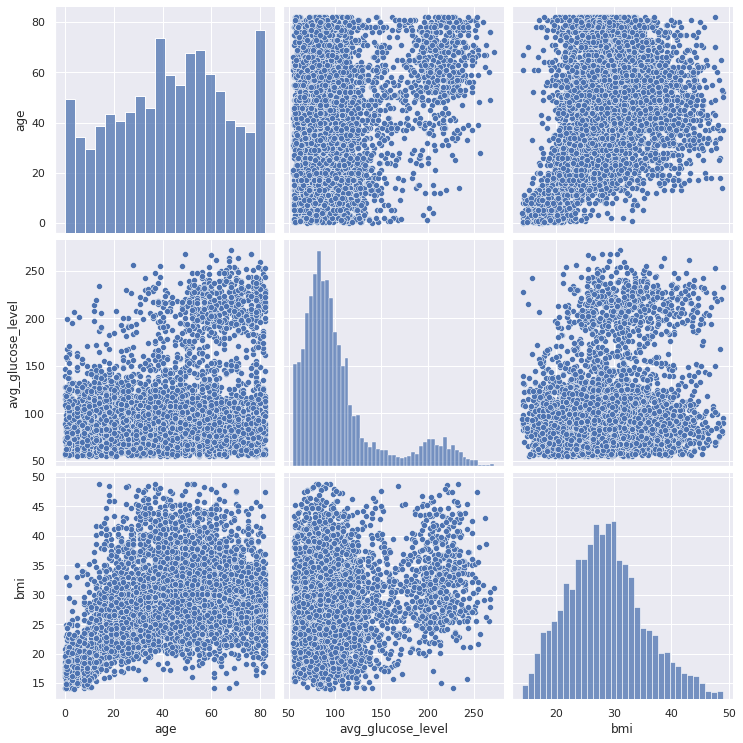

In [4]:
sns.pairplot(df.loc[:, ['age', 'avg_glucose_level', 'bmi']], palette = 'Set1', height = 3.5)

## 

## Plots of categorical variables vs Age

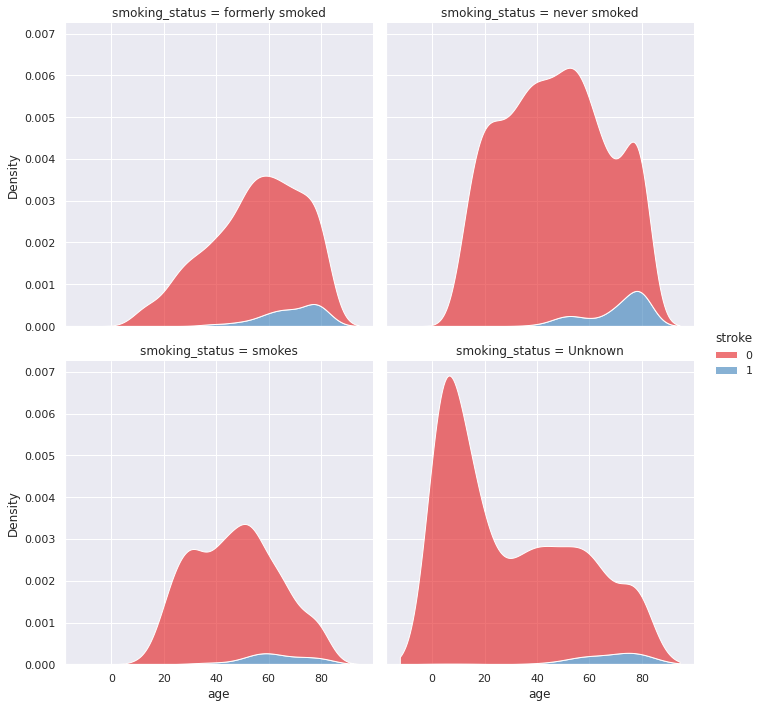

In [5]:
sns.displot( df,x = 'age', hue = 'stroke',col = 'smoking_status', kind = 'kde',
            multiple="stack", palette = 'Set1', alpha = 0.6, col_wrap = 2)

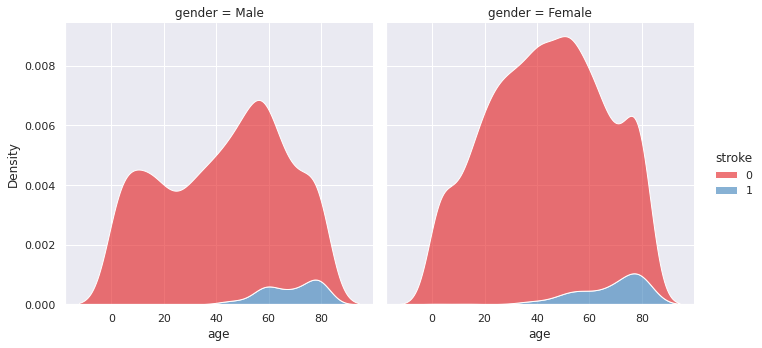

In [6]:
sns.displot( df,x = 'age', hue = 'stroke',col = 'gender',  multiple="stack", palette = 'Set1', kind = 'kde',alpha = 0.6)

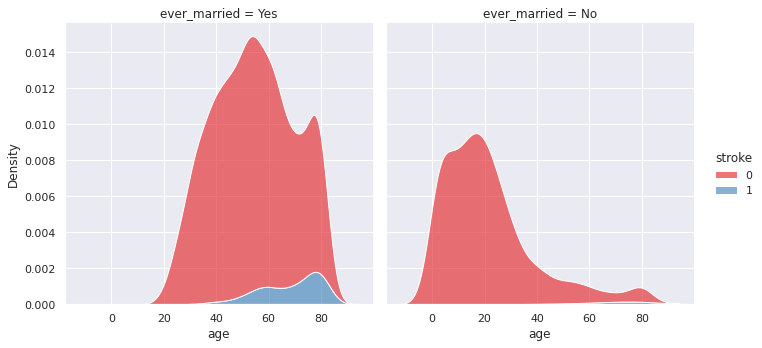

In [7]:
sns.displot( df,x = 'age', hue = 'stroke',col = 'ever_married',  multiple="stack", palette = 'Set1', kind = 'kde',alpha = 0.6)

It looks like that married people are candidates for stroke but in fact the stroke cases are strongly correlated with Age. Majority of unmarried people are less than 40 years old and therefore with low risk of stroke

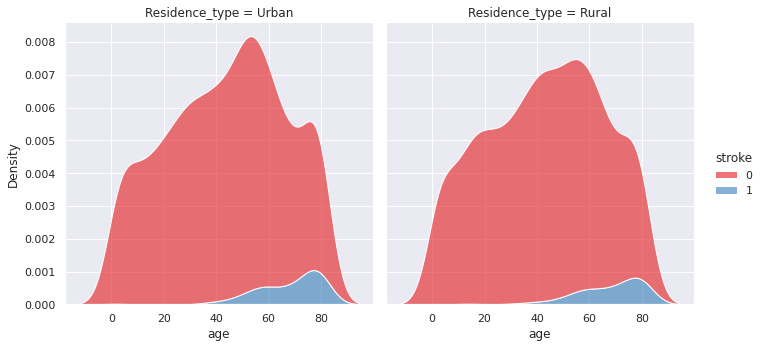

In [8]:
sns.displot( df,x = 'age', hue = 'stroke',col = 'Residence_type',  multiple="stack", palette = 'Set1', kind = 'kde',alpha = 0.6)

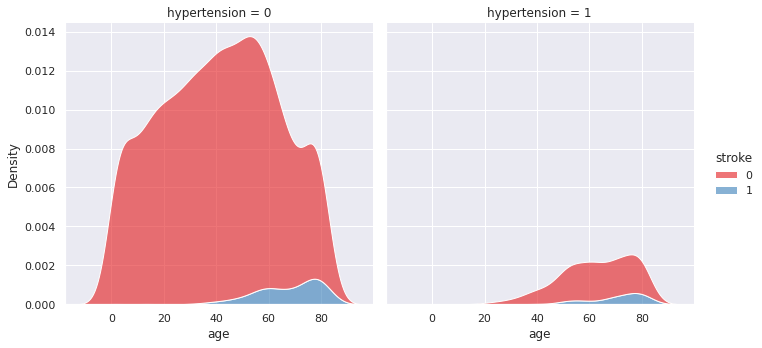

In [9]:
sns.displot( df,x = 'age', hue = 'stroke',col = 'hypertension',  multiple="stack", palette = 'Set1', kind = 'kde',alpha = 0.6)

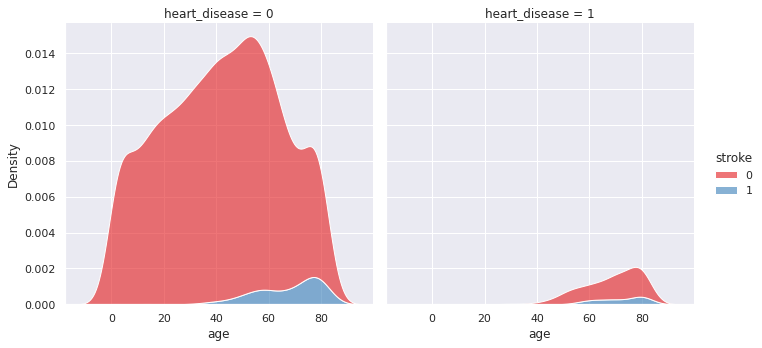

In [10]:
sns.displot( df,x = 'age', hue = 'stroke',col = 'heart_disease',  multiple="stack", palette = 'Set1', kind = 'kde',alpha = 0.6)

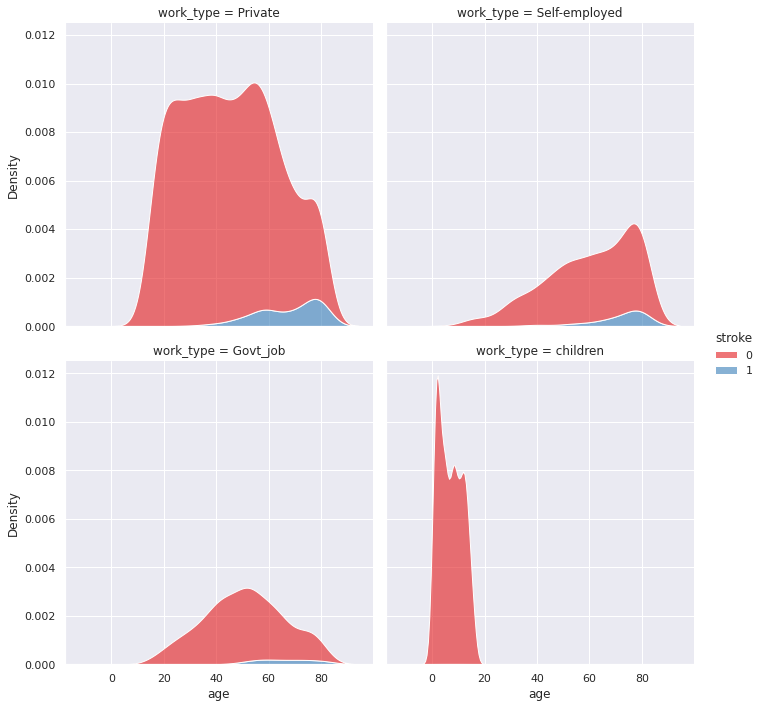

In [11]:
sns.displot( df,x = 'age', hue = 'stroke',col = 'work_type',  multiple="stack", palette = 'Set1', kind = 'kde',alpha = 0.6, col_wrap = 2)

## Age vs BMI vs Smoking Status plot

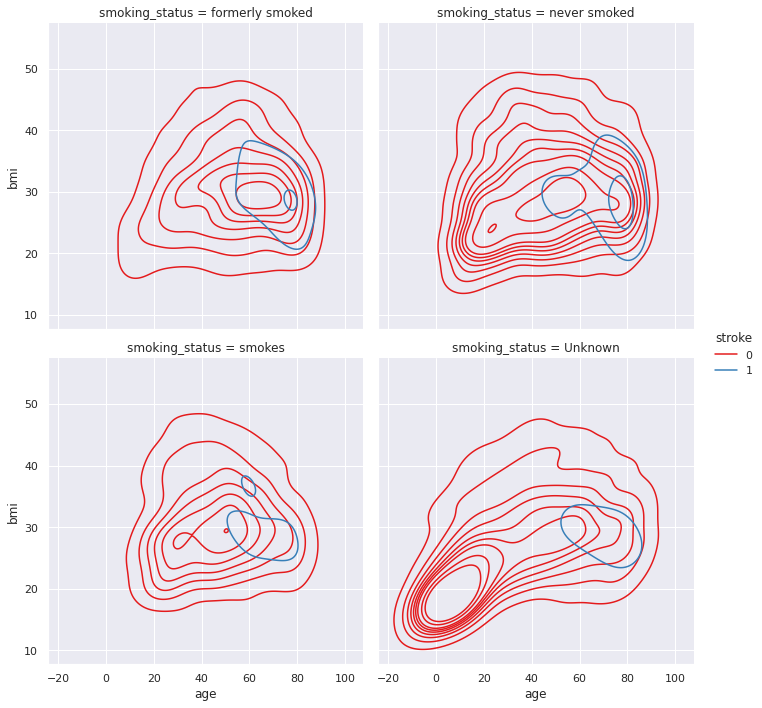

In [12]:
ax = sns.displot( data = df,x = 'age',y = 'bmi',  hue = 'stroke',col = 'smoking_status', col_wrap = 2, 
            palette = 'Set1', kind = 'kde')#, scatter_kws={'alpha':0.6})

### 

## 2. Feature Transformation

## 2.1 Undersampling the minority class

[Text(0.5, 1.0, 'Target Distribution')]

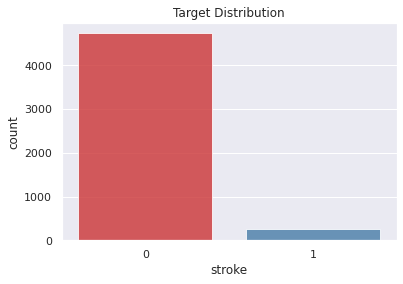

In [13]:
#our dataset is highly imbalanced
sns.countplot(x = df['stroke'], palette = 'Set1', alpha = 0.8).set(title='Target Distribution')

[Text(0.5, 1.0, 'Undersampled Target Distribution')]

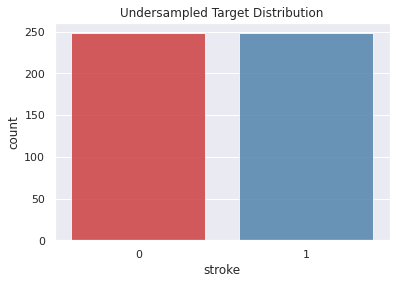

In [14]:
# SEED = 42
# #undersample the data
df_under = pd.concat([df.loc[df['stroke'] == 1], df.loc[df['stroke'] == 0].sample(int(len(df.loc[df['stroke'] == 1])*1), random_state = SEED)]).reset_index(drop = True)

X = df_under.drop(columns = ['stroke'])
y = df_under['stroke']
#smt = SMOTE(random_state=42)
#X, y = smt.fit_resample(X,  y)

#plot the undersampled target
sns.countplot(x = y, palette = 'Set1', alpha = 0.8).set(title='Undersampled Target Distribution')

## 2.2 One-Hot encoding of Categorical features

In [15]:
#categorical features
# for cat in ['gender', 'work_type', 'ever_married', 'Residence_type', 'smoking_status']:
#     le = LabelEncoder()
#     X[cat] = le.fit_transform(X[cat])



#get dummies 
X.replace({'gender':{'Male':0,'Female':1}, 'ever_married':{'Yes':0,'No':1}}, inplace=True);
X = pd.get_dummies(X, columns = ['work_type', 'Residence_type','smoking_status']);

## 2.3 Creating New Features

In [16]:
#creating sum features
X['age_glucose_s'] = X['age'] + X['avg_glucose_level']
X['age_bmi_s'] = X['age'] + X['bmi']

## 2.4 Numerical features transformation

### Perform log and power transformation to reduce the skewness of the numerical features

Text(0.5, 1.0, 'exp of age')

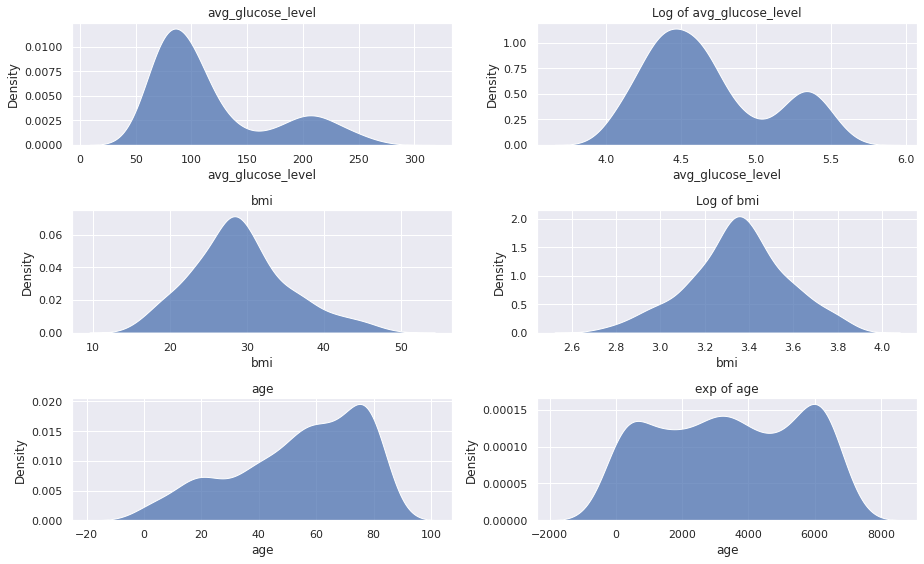

In [17]:
fig, ax = plt.subplots(3,2, figsize = (13,8), tight_layout = True)

sns.kdeplot(X['avg_glucose_level'], multiple = 'stack', ax = ax[0][0], palette = 'Set1')
ax[0][0].set_title('avg_glucose_level')
sns.kdeplot(np.log(X['avg_glucose_level']), multiple = 'stack', ax = ax[0][1], palette = 'Set1')
ax[0][1].set_title('Log of avg_glucose_level')
                   
sns.kdeplot(X['bmi'], multiple = 'stack', ax = ax[1][0], palette = 'Set1')
ax[1][0].set_title('bmi')
sns.kdeplot(np.log(X['bmi']), multiple = 'stack', ax = ax[1][1], palette = 'Set1')
ax[1][1].set_title('Log of bmi')

sns.kdeplot(X['age'], multiple = 'stack', ax = ax[2][0], palette = 'Set1')
ax[2][0].set_title('age')
sns.kdeplot(np.power(X['age'],2), multiple = 'stack', ax = ax[2][1])
ax[2][1].set_title('exp of age')

In [18]:
#create perform transformations
X['avg_glucose_level'] = np.log(X['avg_glucose_level'])
X['bmi'] = np.log(X['bmi'])
X['age'] = np.power(X['age'],2)

In [19]:
X.head(3)

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age_glucose_s,age_bmi_s
0,0,4489.0,0,1,0,5.432367,3.600048,0,1,0,0,0,1,0,1,0,0,295.69,103.6
1,0,6400.0,0,1,0,4.662684,3.481240,0,1,0,0,1,0,0,0,1,0,185.92,112.5
2,1,2401.0,0,0,0,5.143008,3.538057,0,1,0,0,0,1,0,0,0,1,220.23,83.4


## 3. Model Training and Evaluation

### We'll use KFold CV with 5 Folds to evaluate our model

In [20]:
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)

CV_score_array = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"Fold: {fold+1},", end=' ')
    X_train, X_valid = X.values[train_idx, :], X.values[test_idx, :]
    y_train, y_valid = y[train_idx], y[test_idx]
    
    
    smt = SMOTE(random_state=42)
    X_train, y_train = smt.fit_resample(X_train,  y_train)
    

    clf =  Pipeline([ #('scaler', StandardScaler()),
                    ('clf', RandomForestClassifier( random_state = SEED))])

    clf.fit(X_train, y_train)

    yhat_valid =  clf.predict(X_valid)
    
    f_score = f1_score(y_valid,yhat_valid)
    print('F1 Score: ' + str(f_score))
    print(classification_report(y_valid,yhat_valid))

    CV_score_array.append(f_score)
    
print('Average F1 Score 5 Folds: ' + str(np.array(CV_score_array).mean()))

Fold: 1, F1 Score: 0.7358490566037736
              precision    recall  f1-score   support

           0       0.75      0.66      0.70        50
           1       0.70      0.78      0.74        50

    accuracy                           0.72       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.72      0.72      0.72       100

Fold: 2, F1 Score: 0.8035714285714286
              precision    recall  f1-score   support

           0       0.86      0.65      0.74        49
           1       0.73      0.90      0.80        50

    accuracy                           0.78        99
   macro avg       0.80      0.78      0.77        99
weighted avg       0.79      0.78      0.77        99

Fold: 3, F1 Score: 0.8125
              precision    recall  f1-score   support

           0       0.79      0.86      0.82        49
           1       0.85      0.78      0.81        50

    accuracy                           0.82        99
   macro avg       0.82   